# Exploración de datos

Primera exploración de datos y prueba de concepto para identificar si los datos que tenemos del DENUE + OSM sirven.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
import numpy as np
import src 
import networkx as nx
%matplotlib inline

In [4]:
ox.config(data_folder='../data',cache_folder='../data/raw', use_cache=True,log_console=True)

## Configuración
Variables para configurar el script: 

- bbox Coordenadas a utilizar para la descarga de datos (Lista con Norte, Sur, Este, Oeste)
- city (Nombre de la ciudad, abreviación, se usara para guardar los datos)

In [34]:
city = 'GDL'
bbox = [20.971699,20.354928,-102.933655,-103.688965] 
#Área Metropolitana Guadalajara

## Descarga de red
La red se descarga de OpenStreetMaps usando OSMnx para generar una red peatonal. 

In [35]:
polygon = src.create_polygon(bbox,city,save=False)
poly_geom = polygon['geometry'][0]

In [36]:
G = ox.graph_from_polygon(poly_geom,network_type='walk',name=city)

## DENUE
Cargar los datos del DENUE para usarlos como destinos para el cálculo de las distancias en la red. 

Filtrar los datos para tener sólamente datos de farmacias y hacer un clip de los datos de México y obtener los datos que estén dentro del polígono de interés.

In [12]:
gdf = gpd.read_file('../data/external/DENUE/denue_00_46321-46531_shp/conjunto_de_datos/denue_inegi_46321-46531_.shp')
gdf = gdf[(gdf['codigo_act']=="464111")|(gdf['codigo_act']=="464112")]
gdf_f = gpd.clip(gdf,polygon)

### Encontrar intersecciones más cercanas

Para poder hacer el cálculo de caminos más cortos es necesario encontrar cuál es la intersección (nodo) más cercano a cada una de las farmacias, la siguiente función toma la red y el dataframe y caclcula las intersecciones más cercanas usando OSMnx.

In [13]:
gdf_f = src.find_nearest(G,gdf_f)

In [16]:
gdf_f.to_file(filename='../data/processed/ammenities_{}.geojson'.format(city), driver='GeoJSON')

In [14]:
g, weights, node_mapping = src.to_igraph(G)

### Seeds 

Para calcular los caminos más cortos es necesario tener los puntos a los que se quiere llegar, en este caso farmacias, la función `get_seeds(gdf, node_mapping)` toma el archivo que tiene las farmacias y el mapping de los nodos de la red original y la de igraph y regresa un arreglo de numpy con los nodos a usar como semillas.

In [19]:
seeds = src.get_seeds(gdf_f, node_mapping)

## Caminos más cortos

El siguiente paso es calcular el camino más corto entre todos los nodos de la red a los puntos de destino (farmacias), usando la función `python voronoi_cpu(g, weights, seeds)` 

In [21]:
voronoi_assignment = src.voronoi_cpu(g, weights, seeds)
distances = src.get_distances(g,seeds,weights,voronoi_assignment)
df = pd.DataFrame(node_mapping ,index=[0]).T
df['dist'] = distances

## Visualización
Resultado de los caminos más cortos de todas las intersecciones a la farmacia más cercana.

In [52]:
nodes, edges = ox.graph_to_gdfs(G)

In [53]:
nodes=pd.merge(nodes,df,left_index=True,right_index=True)

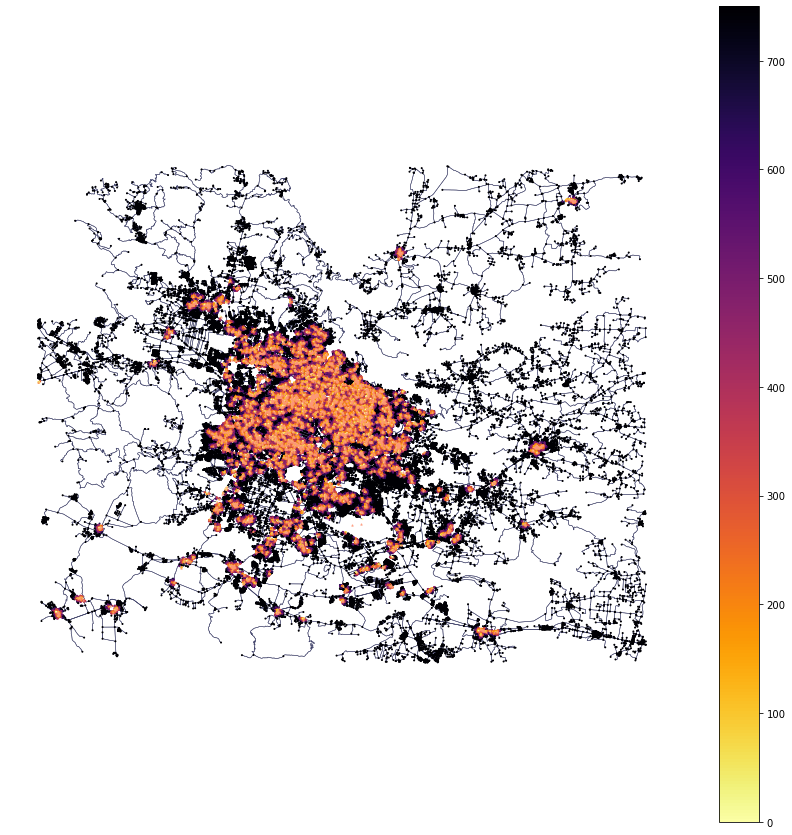

In [57]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
edges.plot(ax=ax, linewidth=0.5, color='#41436A',zorder=0)
nodes.plot(column='dist',cmap='inferno_r',ax=ax,s=1,legend=True, zorder=1, vmax=750)
gdf_f.plot(ax=ax, zorder=3, marker='^' ,markersize=2, alpha=0.75,color='#FE9677',legend=False)
ax.axis('off');

In [63]:
nodes = nodes.drop(0,axis=1)
nodes.to_file("../data/processed/GDL_nodes_distance.geojson", driver='GeoJSON')